In [1]:
import sys
import csv
import math
import copy
import time
import numpy as np
from collections import Counter
from numpy import *
import pandas as pd
import statistics 

## Multiclass classifier decision tree using ID3 algorithm

In [2]:
feature = []

### Normalize Data

In [3]:
def normalize(matrix):
#  transfer the data metrix to np array in float type.
    X = np.asarray(matrix)
    
    #normalizing matrix
    X = (X-np.amin(X,axis=0))/(np.amax(X,axis=0)-np.amin(X,axis=0))
    
    return X

### Loading Iris Dataset 

In [4]:
# function to read and store data for the iris dataset
def load_csv(file):
    
    #reading and storing features
    X = np.empty((150,4))
    X[:,0] = np.genfromtxt(file, delimiter = ",", dtype='float', usecols = 0)
    X[:,1] = np.genfromtxt(file, delimiter = ",", dtype='float', usecols = 1)
    X[:,2] = np.genfromtxt(file, delimiter = ",", dtype='float', usecols = 2)
    X[:,3] = np.genfromtxt(file, delimiter = ",", dtype='float', usecols = 3)
    
    #reading and storing labels
    y = np.empty((150,1))
    y = np.genfromtxt(file, delimiter = ",", dtype = "S", usecols = 4)
    y = y.reshape((150,1))
    
    print(X.shape)
    print(y.shape)
    
    #joining the features and labels
    arr = np.hstack((X,y))
    
    return arr

### Loading Spambase Dataset

In [5]:
# function to read and store data for the spambase dataset
def load_csvT(file):
    X = np.empty((4601,57))
    
    for i in range(57):
        X[:,i] = np.genfromtxt(file, delimiter = ",", dtype='float', usecols = i)
    
    y = np.empty((4601,1))
    y = np.genfromtxt(file, delimiter = ",", dtype = "S", usecols = 57)
    y = y.reshape((4601,1))
    
    print(X.shape)
    print(y.shape)
    
    arr = np.hstack((X,y))
    return arr

### Shuffling Data

In [6]:
#randomly shuffling an array
def random_numpy_array(ar):
    np.random.shuffle(ar)
    return ar

### Generating Training and Testing Data for 10 Folds

In [7]:
#generating training labels, training features, test labels, and test training
def generate_set(X):
    
    y = X[:,-1]
    y = y.reshape(len(y),1)
    
    # removing labels from data
    X = np.delete(X, -1, axis=1)
    X = X.astype(np.float)

    # normalizing data 
    X = normalize(X)

    # adding the labels back to the normiazlied data
    X = np.hstack((X,y))

    # storing the size of rows of the normalized data
    rows = len(X)
    
    # getting 10% of the data to use for testing
    nTests = int(rows*0.1)

    # initializing the starting and ending indices of testing data
    startTest = 0
    endTest = nTests

    # initializing lists to store testing and training data
    testFeatures = []
    testLabels = []

    trainingFeatures = []
    trainingLabels = []

    # generating sets for 10-fold cross-validation:
    for i in range(10):
        
        # storing test set for corss-validation
        testData = X[startTest:endTest]

        # getting training data
        trainingDataB = X[:startTest]
        trainingDataA = X[endTest:]

        trainingData = np.concatenate((trainingDataB,trainingDataA))

        # storing labels for testing and training data
        testDataLabels = testData[:,-1]
        testDataLabels = testDataLabels.flatten()

        trainingDataLabels = trainingData[:,-1]
        trainingDataLabels = trainingDataLabels.flatten()

        # excluding labels from testing and training data
        testData = testData[:,0:-1]
        trainingData = trainingData[:,0:-1]

        
        testFeatures.append(testData)
        testLabels.append(testDataLabels)

        trainingFeatures.append(trainingData)
        trainingLabels.append(trainingDataLabels)

        # updating the testing data index
        startTest = endTest + 1
        endTest = endTest + nTests + 1


    # returning the fold list that contain data and label for both training and testing set
    return testFeatures, testLabels, trainingFeatures, trainingLabels


### Building Dictionary for Features and Values

In [8]:
#building a dictionary to store features and their respective values
def build_dict_of_attributes_with_class_values(X,y): 
    
    featureDict = dict()
    
    features = []

    # populating dictionary for each feature
    for i in range(X.shape[1]):
        # storing the feature index
        featureIndex = i
    
        # finding all the values corresponding to this feature
        values = []
        for row in X:
            values.append(row[featureIndex])

        attributes = []

        # for each value of this feature
        for i,value in enumerate(values):

            attributeValues = []
            # storing value
            attributeValues.append(value)
            
            # storing label corresponding to value
            attributeValues.append(y[i])

            attributes.append(attributeValues)

        # adding attribute list to the dict according to the feature index
        featureDict[featureIndex] = attributes
        
        # storing feature index
        features.append(featureIndex)

    return featureDict, features


### Calculating Entropy 

In [9]:
# Iterative Dichotomiser 3 entropy calculation
def entropy(y):

    frequencyDict = dict()

    # initializing cumulative entropy to 0
    allEntropy = 0

    # counting the number of times each labels occur
    for i in y:
        if i in frequencyDict.keys():
            frequencyDict[i] += 1;
        else:
            frequencyDict[i] = 1

    # calculating cumulative entropy
    entropy = []
    for i,key in enumerate(frequencyDict.keys()):
        p = frequencyDict[key]/len(y)
        entropy.append(-p*math.log2(p))
        
    for e in entropy:
        allEntropy = allEntropy + e

    return allEntropy

### Node Class

In [10]:
class Node(object):
    def __init__(self, val, lchild, rchild,thea,leaf):
        self.root_value = val
        self.root_left = lchild
        self.root_right = rchild
        self.theta = thea
        self.leaf = leaf

    # method to identify if the node is a leaf node
    def is_leaf(self):
        if self.root_left == None and self.root_right == None:
            return True
        else:
            return False

    # method to return threshold value
    def ret_thetha(self):
        return self.theta
    
    # method return root value
    def ret_root_value(self):
        return self.root_value
    
    # method return left tree
    def ret_llist(self):
        return self.root_left

    # method return right tree
    def ret_rlist(self):
        return self.root_right

    def __repr__(self):
        return "(%r, %r, %r, %r)" %(self.root_value,self.root_left,self.root_right,self.theta)


### Decision Tree Class

In [11]:
class DecisionTree(object):

    fea_list = []

    def __init__(self):
        self.root_node = None

    # method to return the major class value
    def cal_major_class_values(self,class_values):
        data = Counter(class_values)
        data = data.most_common(1)[0][0]
        return data

    # method to calculate the best threshold value for each feature
    def cal_best_theta_value(self,ke,attri_list):
        
        # initializing list to store data
        data = []

        # initializing list to store labels
        labels = []

        # for each attribute in the attri_list
        for i in range(len(attri_list)):
            # storing data
            data.append(float(attri_list[i][0]))

            # storing feature values
            labels.append(attri_list[i][1])

        # calculating base entropy
        baseEntropy = entropy(labels)

        # initializing maximum information gain to 0
        maxInfoGain = 0

        theta = 0

        # initializing lists to store left and right indices
        leftIndex = []
        rightIndex = []

        # initializing a list to store the labels
        splitLabels = []

        # storing the data
        np.sort(data)

        # for each index of data
        for i in range(len(data)-1):
            
            # calculating the current threshold
            currentTheta = (data[i]+data[i+1])/2

            # initializing lists to store indices and values
            lessIndex = []
            lessValue = []

            moreIndex = []
            moreValue = []

            # for each index and value in attri_list
            for c,j in enumerate(attri_list):
                # split values based on threshold 
                if (float(j[0]) <= currentTheta):
                    lessIndex.append(c)
                    lessValue.append(j[1])
                    
                else:
                    moreIndex.append(c)
                    moreValue.append(j[1])

            # calculating the entropy of the two lists
            entropyLess = entropy(lessValue)
            entropyMore = entropy(moreValue)
            

            # calculating information gain
            entropyLess = entropyLess*(len(lessValue)/(len(lessValue)+len(moreValue)))
            entropyMore = entropyMore*(len(moreValue)/(len(lessValue)+len(moreValue)))
            infoGain = baseEntropy - (entropyLess + entropyMore)

            # comparing current information gain to max information gain and updating values accordingly
            if infoGain > maxInfoGain:
                maxInfoGain = infoGain
                leftIndex = lessIndex
                rightIndex = moreIndex
                splitLabels = concatenate((lessIndex,moreIndex))
                theta = currentTheta

        return maxInfoGain, theta, leftIndex, rightIndex, splitLabels

    # method to select the best feature
    def best_feature(self,dict_rep):

        key = None

        # initializing max information gain to -1
        maxInfoGain = -1

        # initializing maximum threshold value
        maxTheta = 0

        # initializing lists
        maxLeft = []
        maxRight = []
        bestLabel = []
        results = []
        
        # for each key in dict_rep:
        for ke in dict_rep.keys():
            # finding best threshold value for current feature
            infoGain, theta, leftIndex, rightIndex, splitLabels = self.cal_best_theta_value(ke,dict_rep[ke])

            # checking if current info gain is better than max info gain
            if infoGain > maxInfoGain:
                maxInfoGain = infoGain
                maxTheta = theta
                maxLeft = leftIndex
                maxRight = rightIndex
                bestLabel = splitLabels 
                key = ke


        # storing final results
        results.append(key)
        results.append(maxTheta)
        results.append(maxLeft)
        results.append(maxRight)
        results.append(bestLabel)

        return results

    def get_remainder_dict(self,dict_of_everything,index_split):
        global fea_list

        splitDict = dict()

        # for each key in dict_of_everything
        for ke in dict_of_everything.keys():
            values = []
            modified = []

            # getting the corresponding values of this feature key
            keValues = dict_of_everything[ke]
    
            for i,value in enumerate(keValues):
                # if the index is not in the index_split, add it to remainder dictionary
                if i not in index_split:
                    values.append(value[1])
                    modified.append(value)

            splitDict[ke] = modified
            
        return splitDict, values

    # method to create decision tree
    def create_decision_tree(self, dict_of_everything,class_val,eta_min_val):
        global fea_list
        
        # if there is only one label in the set, return leaf node with said label
        if (len(set(class_val))==1):
            return Node(class_val[0], None, None, 0, True)
        
        #if the length of the set is less than the set minimum value
        elif len(class_val) < eta_min_val:
            #finding the major class label and returning leaf node with said label
            maxVal = self.cal_major_class_values(class_val)
            return Node(maxVal, None, None, 0, True)

        else:
            # finding the best feature 
            bestList = self.best_feature(dict_of_everything)
            key = bestList[0]
            theta = bestList[1]
            leftSplit = bestList[2]
            rightSplit = bestList[3]
            classLabels = bestList[4]
            

            # getting left tree data
            leftTree, leftValues = self.get_remainder_dict(dict_of_everything, leftSplit)

            # getting right tree data
            rightTree, rightValues = self.get_remainder_dict(dict_of_everything, rightSplit)

            # getting left and right trees
            leftChild = self.create_decision_tree(leftTree,leftValues, eta_min_val)
            rightChild = self.create_decision_tree(rightTree,rightValues, eta_min_val)

            root_node = Node(key,leftChild, rightChild,theta,False)

            return root_node
            
    #method to fit the decision tree
    def fit(self, dict_of_everything,cl_val,eta_min_val):
        global fea_list
        
        # setting the root node using the function create_decision_tree()
        rootNode = self.create_decision_tree(dict_of_everything,cl_val,eta_min_val)

        return rootNode

    def classify(self,row,root):
        
        testDict = dict()

        # populating dictionary with row data
        for k,j in enumerate(row):
            testDict[k] = j
                                             
        # setting the current node to root
        currentNode = root

        # getting value for current node
        val = float(row[currentNode.root_value])

        # while the current node is not leaf
        while (not currentNode.leaf):
            # if the current is greater than the threshold, classify left
            if (val > currentNode.theta):
                currentNode = currentNode.root_left
                
            # if the current is less than the threshold, classify right
            elif (val <= currentNode.theta):
                currentNode = currentNode.root_right
                
        return currentNode.root_value
        
    # method to predict the labels for the test data
    def predict(self, X, root):

        predictions = []
        for row in X:
            predictions.append(self.classify(row,root))

        return predictions

### Calculating Accuracy of Predictions

In [12]:
# calculating the predicited accuracy
def accuracy_for_predicted_values(test_class_names1,predicted):

    trueCount = 0
    falseCount = 0

    # counting correct and incorrect predictions
    for i in range(len(test_class_names1)):
        sth = test_class_names1[i].decode('UTF-8')
        sth2 = predicted[i].decode('UTF-8')
        #print(sth, sth2)
        if sth == sth2:
            trueCount+=1
        else:
            falseCount+=1
            
    # calculating accuracy
    accuracy = float(trueCount/(trueCount+falseCount))
  
    return accuracy

In [13]:
allAccuracies = []

def main(num_arr, eta_min):

    # randomly shufflign the data
    X = random_numpy_array(num_arr)

    #dividing data into test labels,test features,training labels, training features
    testF, testL, trainF, trainL = generate_set(X)
    
#     init cumulate acc to 0
    accuracy = 0
    accuracies = []

    #ten fold iteration 
    for i in range(10):
        
        #build a dictionary with class labels and respective features values belonging to that class
        featuresDictionary, featuresList = build_dict_of_attributes_with_class_values(trainF[i],trainL[i])
        
        #instantiate decision tree instance
        decisionTree = DecisionTree()
       
        rootNode = decisionTree.fit(featuresDictionary, trainL[i], eta_min)
        
        #predict the class labels for test features
        predictedLabels = decisionTree.predict(testF[i],rootNode)
        
        #calculate the accuracy for the predicted values    
      
        accu = float(accuracy_for_predicted_values(testL[i],predictedLabels))
        accuracies.append(accu)
        accuracy+=accu

    
        print("Accuracy is ",accu)
    standardDeviation = statistics.stdev(accuracies)
    accuracies.append(float(accuracy)/10)
    accuracies.append(standardDeviation)
    allAccuracies.append(accuracies)
    print("Accuracy across 10-cross validation for",eta_min,"is",float(accuracy)/10)


### Classifying Iris Dataset

In [14]:
eta_min_list = [5,10,15,20]
newfile = "iris.csv"
num_arr = load_csv(newfile)
for i in eta_min_list:
    main(num_arr,i)

(150, 4)
(150, 1)
Accuracy is  0.8666666666666667
Accuracy is  1.0
Accuracy is  0.9333333333333333
Accuracy is  0.7333333333333333
Accuracy is  0.9333333333333333
Accuracy is  0.9333333333333333
Accuracy is  0.8
Accuracy is  0.9333333333333333
Accuracy is  1.0
Accuracy is  1.0
Accuracy across 10-cross validation for 5 is 0.9133333333333333
Accuracy is  0.8666666666666667
Accuracy is  1.0
Accuracy is  1.0
Accuracy is  0.9333333333333333
Accuracy is  0.9333333333333333
Accuracy is  0.7333333333333333
Accuracy is  0.9333333333333333
Accuracy is  0.9333333333333333
Accuracy is  1.0
Accuracy is  1.0
Accuracy across 10-cross validation for 10 is 0.9333333333333333
Accuracy is  1.0
Accuracy is  0.9333333333333333
Accuracy is  1.0
Accuracy is  0.8666666666666667
Accuracy is  0.9333333333333333
Accuracy is  1.0
Accuracy is  0.8666666666666667
Accuracy is  0.8666666666666667
Accuracy is  1.0
Accuracy is  1.0
Accuracy across 10-cross validation for 15 is 0.9466666666666667
Accuracy is  0.93333333

### Displaying Results of Iris Dataset

In [15]:
import matplotlib.pyplot as plt

Iris Dataset Classification Results: 


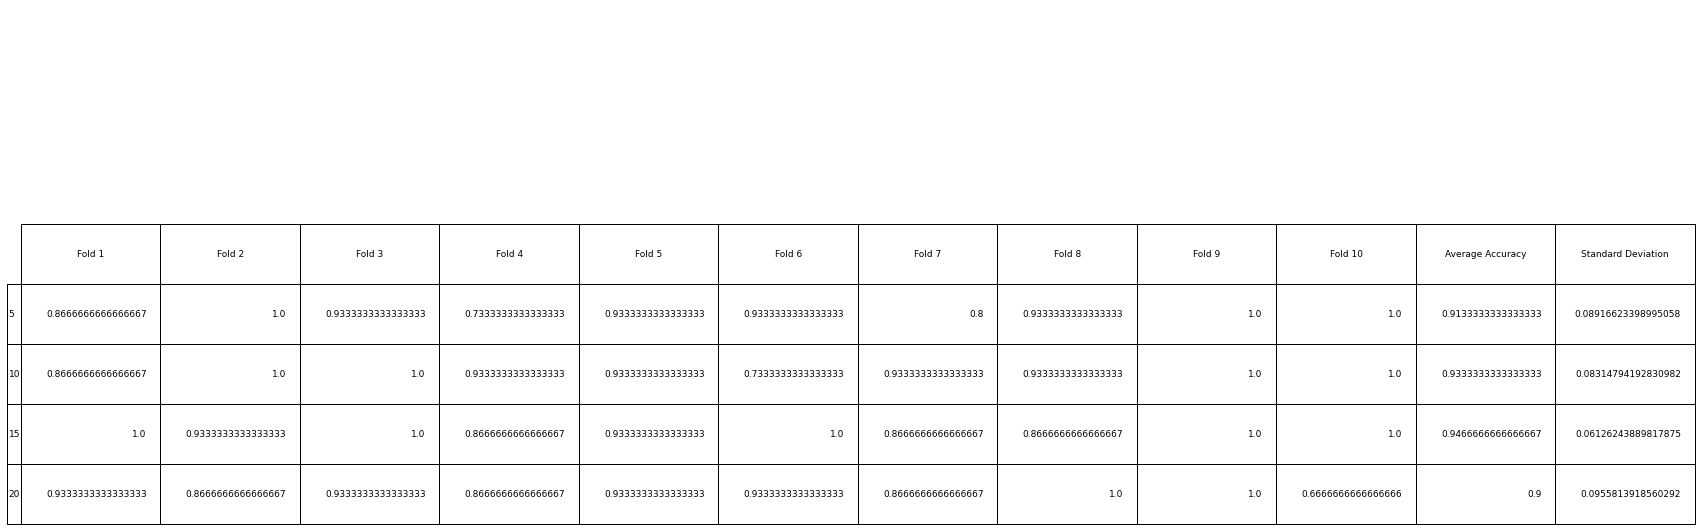

Overall Average Accuracy:  0.9233333333333333


In [16]:
folds = ["Fold 1","Fold 2","Fold 3","Fold 4","Fold 5","Fold 6","Fold 7","Fold 8","Fold 9","Fold 10","Average Accuracy","Standard Deviation"]

rows = ["5","10","15","20"]
columns = [folds]

val1 = [i for i in eta_min_list] 
val2 = [i for i in folds] 
val3 = [[c for c in allAccuracies[r]] for r in range(len(allAccuracies))]

resultsTable = plt.table(cellText = val3,
                            rowLabels = val1,
                            colLabels = val2)

# Deleting axis and ticks to only display confusion matrix
for numbers in ['right','top','bottom','left']:
    plt.gca().spines[numbers].set_visible(False)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

print("Iris Dataset Classification Results: ")

resultsTable.scale(5,5)
resultsTable.set_fontsize(50)

plt.show()

averageAccuracies = []
for i in allAccuracies:
    averageAccuracies.append(i[10])
    
overallAverage = sum(averageAccuracies)/4
overallStandardDeviation = statistics.stdev(averageAccuracies)
print("Overall Average Accuracy: ", overallAverage)